# Measuring the Bias of the Teacher Model

## Imports

In [3]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
# import torch

from typing import Callable, Dict
import numpy as np

from collections import defaultdict
from typing import List
import re

import sys
sys.path.insert(0, '..')
from notifier import Notifier

import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

In [4]:
notifier = Notifier()
notifier.set_usage(True) # Comment out for no notifications

## Functions

In [5]:
def import_predictions(file_path: str, rm_columns: List[str] = [], rename_columns:  Dict[str, str] = {}, parquet_engine: str = "auto", apply_column_funcs: Dict[str, callable] = {}) -> pd.DataFrame:
    """Imports predictions from a file and optionally removes/renames columns. Function documentation generated with Claude Sonnet 4.5
        
        Args:
            file_path (str): Path to the file containing predictions (.csv or .parquet)
            rm_columns (list, optional): List of column names to remove. Defaults to [].
            rename_columns (dict, optional): Dictionary mapping old column names to new names. Defaults to {}.
        
        Returns:
            pd.DataFrame: The processed dataframe with predictions.
        
        Raises:
            ValueError: If file format is unsupported or specified columns don't exist.
        """
    temp_ds = None
    if file_path.endswith('.csv'):
        temp_ds = pd.read_csv(file_path)
    elif file_path.endswith('.parquet'):
        temp_ds = pd.read_parquet(file_path, engine=parquet_engine)
    if temp_ds is None:
        raise ValueError("Unsupported file format. Only .csv and .parquet are supported.")
    
    if len(rm_columns) > 0:
        # Sanity checks for removing columns
        if not all(col in temp_ds.columns for col in rm_columns):
            raise ValueError("One or more columns to remove do not exist in the dataset.")
        # Remove the specified columns
        temp_ds = temp_ds.drop(columns=rm_columns)
    if len(rename_columns) > 0:
        # Sanity checks for renaming columns
        if not all(col in temp_ds.columns for col in rename_columns.keys()):
            raise ValueError("One or more columns to rename do not exist in the dataset.")
        if any(col in temp_ds.columns for col in rename_columns.values()):
            raise ValueError("One or more new column names already exist in the dataset.")
        # Rename the columns
        temp_ds = temp_ds.rename(columns=rename_columns)
    if len(apply_column_funcs) > 0:
        # Sanity checks for applying functions to columns
        if not all(col in temp_ds.columns or col in rename_columns for col in apply_column_funcs.keys()):
            raise ValueError("One or more columns specified for function application do not exist in the dataset.")
        for col, func in apply_column_funcs.items():
            # Check if the function is callable
            if not callable(func):
                raise ValueError(f"The function provided for column '{col}' is not callable.")
            # Set column name after renaming if given initial name
            col_name = col if col in rename_columns else rename_columns[col]
            if col_name not in temp_ds.columns:
                raise ValueError(f"Column '{col}' specified for function application does not exist in the dataset.")
            # Apply the function to the specified column
            temp_ds[col_name] = temp_ds[col_name].apply(func)
    return temp_ds

def import_to_ds(ds: pd.DataFrame, file_path: str, prediction_columns: List[str], column_key: str = 'sentence', rename_columns:  Dict[str, str] = {}, parquet_engine: str = "auto") -> pd.DataFrame:
    """Imports predictions from a file and merges them with the existing dataset. Function documentation generated with Claude Sonnet 4.5
        
        Args:
            ds (pd.DataFrame): The existing dataset to merge predictions into.
            file_path (str): Path to the file containing predictions (.csv or .parquet).
            prediction_column (str): Name of the column containing predictions.
            rename_columns (dict, optional): Dictionary mapping old column names to new names. Defaults to {}.
        
        Returns:
            pd.DataFrame: The dataset with predictions merged in.
        """
    # import the dataframe
    temp_ds = import_predictions(file_path, rename_columns=rename_columns, parquet_engine=parquet_engine)
    merge_key = column_key if column_key in temp_ds.columns else rename_columns.get(column_key, None)
    if merge_key is None:
        raise ValueError(f"Column key '{column_key}' does not exist in the imported dataset.")
    if merge_key not in ds.columns:
        raise ValueError(f"Column key '{column_key}' does not exist in the main dataset.")
    # Set the predicted column name to a renamed column if it is in the renamed columns
    pred_col_names = [col if col not in rename_columns else rename_columns[col] for col in prediction_columns]
    match_columns = set(pred_col_names) - set(temp_ds.columns)
    # Sanity check to ensure all prediction columns exist
    if len(match_columns) > 0:
        raise ValueError(f"{match_columns} columns do not exist in the imported dataset.")
    # Check if any columns already exist in the main dataset
    existing_columns = set(pred_col_names) & set(ds.columns)
    if len(existing_columns) > 0:
        raise ValueError(f"{existing_columns} columns already exist in the main dataset.")
    # Merge the predictions into the main dataset
    temp_ds = temp_ds[[column_key, *pred_col_names]]
    ds = ds.merge(temp_ds, on=column_key, how='left')
    return ds

In [6]:
def compare_differences(df, constants: List[str], variable: str, metric_column: str, curr_info = {}, concat_df=None) -> pd.DataFrame:
    """Compares the differences in means for a variable across different constant categories.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        constants (List[str]): List of column names to keep constant during comparisons.
        variable (str): The variable column name to compare mean values for.
        curr_info (dict, optional): Current information about the constant categories. Defaults to {}.
        concat_df (pd.DataFrame, optional): Dataframe to concatenate results to. Defaults to None.

    Returns:
        pd.DataFrame: A dataframe containing the means for each category of the variable across the constant categories.
    """
    res_df = pd.DataFrame() if concat_df is None else concat_df
    if len(constants) == 0:
        # Base case: calculate means for each category of the variable
        return pd.concat([concat_df,
                          pd.DataFrame([{
                              **curr_info,
                              **{f'{v}_data': df[df[variable] == v][metric_column].to_numpy()#.mean()
                                 for v in df[variable].unique()
                                 if len(df[df[variable] == v]) > 0}
                                 }],)], ignore_index=True)
    # Iterate through each of the values for the columns we want to keep constant among comparisons
    for value in df[constants[0]].unique():
        temp_df = df[df[constants[0]] == value]
        if len(temp_df) == 0:
            continue
        new_constants = constants[1:]
        new_info = curr_info.copy()
        new_info[constants[0]] = value
        res_df = compare_differences(temp_df, new_constants, variable, metric_column, new_info, res_df)
    return res_df

## Analyzing the Accuracy of the Models

In [7]:
teacher_test_df = pd.read_csv("../data/llama3.1/test.csv")
teacher_train_df = pd.read_csv("../data/llama3.1/train.csv")
teacher_test_df['prediction'] = teacher_test_df[['label_0', 'label_1']].to_numpy().argmax(axis=1)
teacher_train_df['prediction'] = teacher_train_df[['label_0', 'label_1']].to_numpy().argmax(axis=1)
print(f"Train:{teacher_train_df.head()}\n")
print(f"Test:{teacher_test_df.head()}\n")

Train:                                                text  label   label_0  \
0  The volleyball genre is strangely overlooked b...      0  0.046020   
1  I got interested in this movie because somebod...      0  0.782700   
2  Sure, I like some indie films. A lot, actually...      0  0.955600   
3  Blademaster is definitely a memorable entry in...      1  0.069030   
4  This World War II Popeye cartoon had some very...      1  0.002823   

   label_1  prediction  
0  0.95400           1  
1  0.21730           0  
2  0.04453           0  
3  0.93100           1  
4  0.99700           1  

Test:                                                text  label   label_0  \
0  This sci-fi great fortunately has little to do...      1  0.001636   
1  Yet another recent comedy that shows that Holl...      0  0.970000   
2  I was looking on Imdbs bottom 100 because i th...      0  0.970000   
3  Bo Derek will not go down in history as a grea...      0  0.925000   
4  During the Civil War, there wer

Teacher Model F1 Score (Train Set): 0.9416


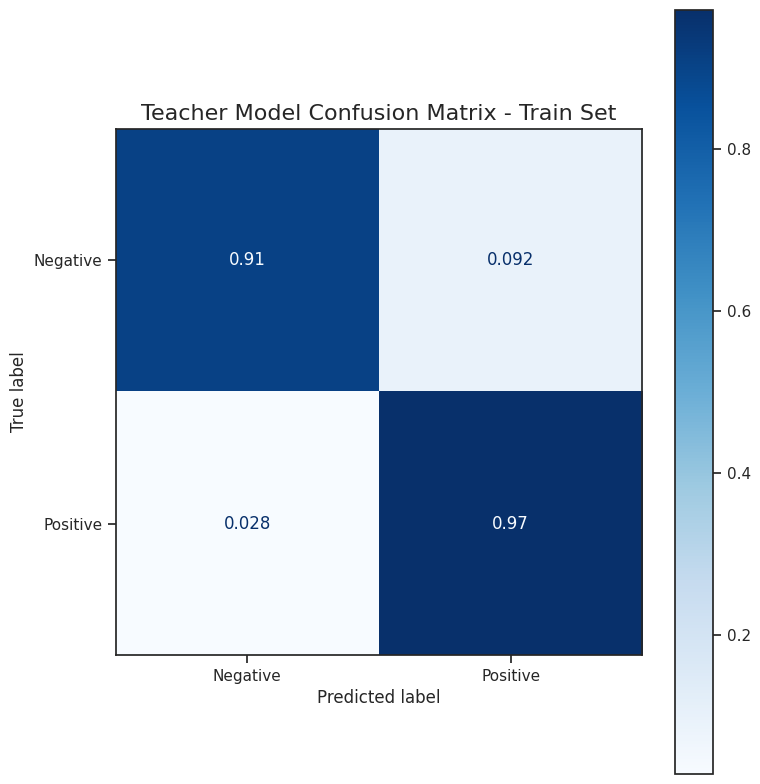

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

train_f1_score = f1_score(
    teacher_train_df['label'], teacher_train_df['prediction']
)

ConfusionMatrixDisplay.from_predictions(
    teacher_train_df['label'], teacher_train_df['prediction'],
    display_labels=["Negative", "Positive"],
    cmap=plt.cm.Blues,
    normalize='true',
    ax = ax
)

ax.set_title("Teacher Model Confusion Matrix - Train Set", fontsize=16)

fig.tight_layout()

fig.savefig("graphs/teacher_model_confusion_matrix_train.png", dpi=300)

print(f"Teacher Model F1 Score (Train Set): {train_f1_score:.4f}")

plt.show()

Teacher Model F1 Score (Test Set): 0.9474


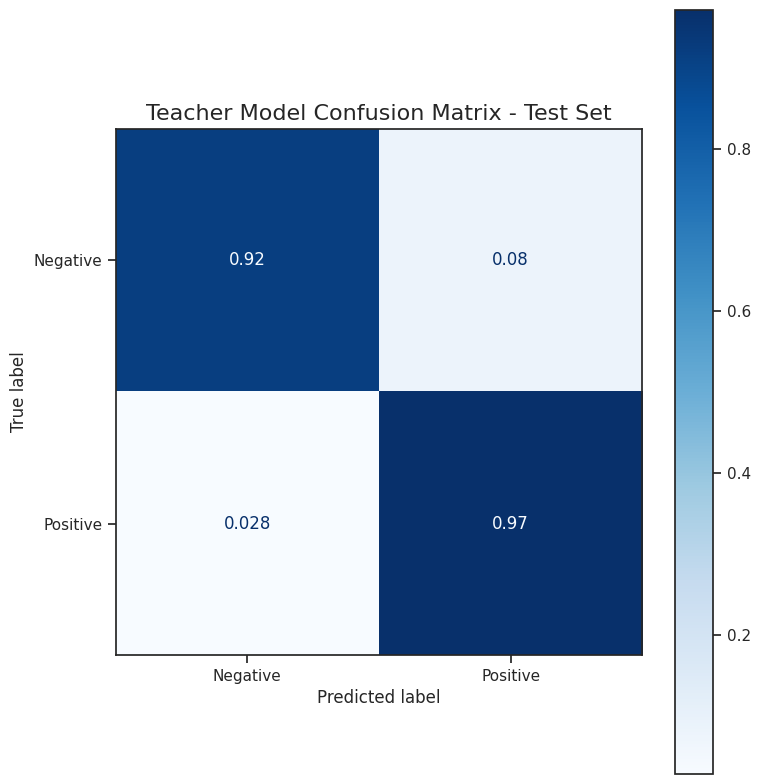

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

test_f1_score = f1_score(
    teacher_test_df['label'], teacher_test_df['prediction']
)


ConfusionMatrixDisplay.from_predictions(
    teacher_test_df['label'], teacher_test_df['prediction'],
    display_labels=["Negative", "Positive"],
    cmap=plt.cm.Blues,
    normalize='true',
    ax = ax
)

ax.set_title("Teacher Model Confusion Matrix - Test Set", fontsize=16)
fig.tight_layout()

fig.savefig("graphs/teacher_model_confusion_matrix_test.png", dpi=300)

print(f"Teacher Model F1 Score (Test Set): {test_f1_score:.4f}")

plt.show()

## Running Teacher Model on the EEC Dataset

### Teacher Parquet Files
---
##### `datasets/teacher_model_predictions.parquet`
This used a set few shot prompt (the code of which is viable below). This was how the test dataset was created.
```python
def model_prompt(text: str, _) -> str:
    prompt_output = f"""Classify the sentiment of the following texts as either Negative, or Positive.

Text: ...but a lousy film. As Maltin says this was Christopher Lee's attempt to make a serious horror film. Well, it is serious...TOO serious! The plot is silly and slow (something about old people inhabiting the bodies of young children to achieve immortality)...the film is all talk talk talk talk talk talk talk about the same things over and over again. I actually dozed off a few times! The film is sooooo dull! The cast sleepwalks through this with the sole exceptions of Peter Cushing and Lee...but this was probably a labor of love for both (they often complained about horror movies being too violent...well, this has NO violence!). Avoid at all costs...unless you have insomnia...this will put you to sleep!
Sentiment: Negative

Text: Considering it was made on a low budget, THE DAY TIME ENDED manages to make the most of its budget with some surprisingly good special effects work.<br /><br />The story involves a family who are about to move into their solar-powered home in an isolated part of the Mojave Desert in southwestern California, only to find it trashed--by motorcycle vandals, they think. But their youngest daughter (Natasha Ryan) has begun to see mysterious things--a green pyramid, strange humanoid figures, etc. And only recently, the light from a trinary star explosion has caused extremely unusual auroras to show up in the desert skies. Thus the family, led by Jim Davis and Dorothy Malone, finds themselves face-to-face with strange alien forces who have put them in a time-and-space warp.<br /><br />Mixing in elements of 2001: A SPACE ODYSSEY and CLOSE ENCOUNTERS OF THE THIRD KIND, THE DAY TIME ENDED, despite its obvious flaws and uneven acting, remains interesting due to the superb special effects work of David Allen. The desert setting is very appropriate for this film's close encounters; and while the movie cannot really be compared with either Kubrick's or Spielberg's films, THE DAY TIME ENDED is much better than many other 2001/CLOSE ENCOUNTERS knock-offs. I give credit to director John 'Bud' Cardos, whose 1977 thriller KINGDOM OF THE SPIDERS made for an interesting precursor to ARACHNOPHOBIA, for at least trying--and on that basis, I give THE DAY TIME ENDED a 7 out of 10.
Sentiment: Positive

Text: I did a review for this director's fictional recreation about BTK. I had also seen this movie and it was terrible. Please save your money and time. This movie was terrible and this director is untalented. I do not understand how he is funding these movies. They are horrible. I have decided to make sure that I check who the writer, director, and producer are, and if this director's name pops up I will not waste my money. There is nothing worse than renting a movie on a Friday night, making the popcorn, and then realizing you have been duped by creative art on the front of the movie box. Stay away. So I guess I should make up some stuff to fill in the lines? I have always checked IMDb for reviews before, but I think I will not anymore. This is ridiculous. I have been corrected in my reviews far too many times. Not enough lines? You may cancel my account. Your site is a pain.
Sentiment: Negative

Text: {text}
Sentiment: """
    return prompt_output
```
#### `datasets/teacher_rand_example_few_shot_predictions.parquet`
This uses a randomized examples for the few shot (3 examples, can be changed). This is to compare it to a set few shot model. The code for this is seen below. This was how the training dataset was created.
```python
def model_prompt(ex: str, labels: dict) -> str:
    examples = teacher_train_df.sample(n=3)
    output = f"Classify the sentiment of the following texts as either {', '.join(list(labels.values())[:-1])}, or {list(labels.values())[-1]}.\n\n"
    if len(examples) > 0:
        for i, row in examples.iterrows():
            output += f'Text: {row["text"]}\nSentiment: {labels[row["label"]]}\n\n'
    output += f'Text: {ex}\nSentiment: '
    return output
```

In [ ]:
# from hugging_face_model import HFModel

# llama_31 = HFModel()

# llama_31.load_model("meta-llama/Meta-Llama-3.1-8B-Instruct")

# llama_31.set_labels({0: "Negative", 1: "Positive"})
# # Randome sample prompt function
# def model_prompt(ex: str, labels: dict) -> str:
#     examples = teacher_train_df.sample(n=3)
#     output = f"Classify the sentiment of the following texts as either {', '.join(list(labels.values())[:-1])}, or {list(labels.values())[-1]}.\n\n"
#     if len(examples) > 0:
#         for i, row in examples.iterrows():
#             output += f'Text: {row["text"]}\nSentiment: {labels[row["label"]]}\n\n'
#     output += f'Text: {ex}\nSentiment: '
#     return output

# llama_31.set_prompt(model_prompt)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded from meta-llama/Meta-Llama-3.1-8B-Instruct on device cuda:0


In [ ]:
# Correct format for downloading raw files from Hugging Face datasets
# ds = pd.read_parquet(
#     "https://huggingface.co/api/datasets/peixian/equity_evaluation_corpus/parquet/first_domain/train/0.parquet"
# )

# label_prob = []
# for sentence in tqdm(ds['sentence']):
#     probs = llama_31.predict(sentence)
#     label_prob.append(probs.numpy())
# # Convert to numpy array and transpose to slice correctly
# label_prob = np.array(label_prob).T
# # Add the probabilities to the dataframe
# ds['0'], ds['1'] = label_prob
# notifier.send_notification("Finished Running through Teacher Model Predictions")
# # Save the dataframe with predictions
# ds.to_parquet("datasets/teacher_rand_example_few_shot_predictions.parquet")
# notifier.send_notification("Saved Teacher Model Predictions to Parquet File")
# ds.head()

  0%|          | 0/8640 [00:00<?, ?it/s]

,sentence,template,person,gender,race,emotion,emotion word,0,1
0,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,0.880842,0.119158
1,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,0.979029,0.020971
2,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated,0.956330,0.043670
3,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged,0.956957,0.043043
4,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed,0.783898,0.216102


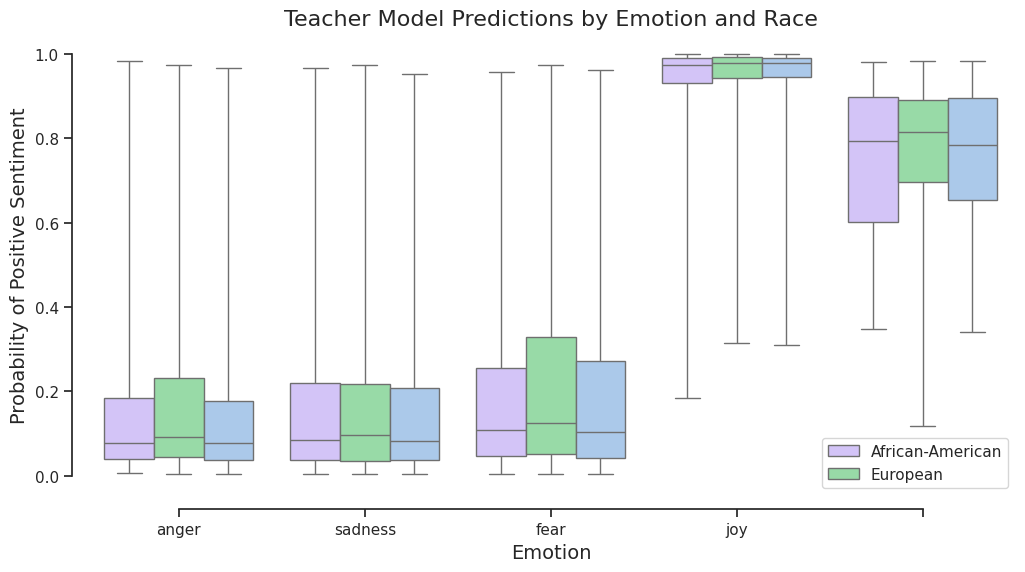

In [10]:
ds = import_predictions("datasets/teacher_rand_example_few_shot_predictions.parquet", rm_columns=['0'], rename_columns={"1": "llama"})

fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    x="emotion", y="llama",
    hue="race", palette=["m", "g", 'b'],
    data=ds,
    whis=(0, 100),
    ax=ax
)

sns.despine(offset=10, trim=True)

ax.legend(loc='lower right')
ax.set_title("Teacher Model Predictions by Emotion and Race", fontsize=16)
ax.set_xlabel("Emotion", fontsize=14)
ax.set_ylabel("Probability of Positive Sentiment", fontsize=14)

ax.legend(loc='lower right')

fig.savefig("graphs/teacher_model_predictions_by_emotion_and_race.png", dpi=300)

notifier.send_image("Teacher Model Predictions by Emotion and Race", "graphs/teacher_model_predictions_by_emotion_and_race.png")

plt.show()

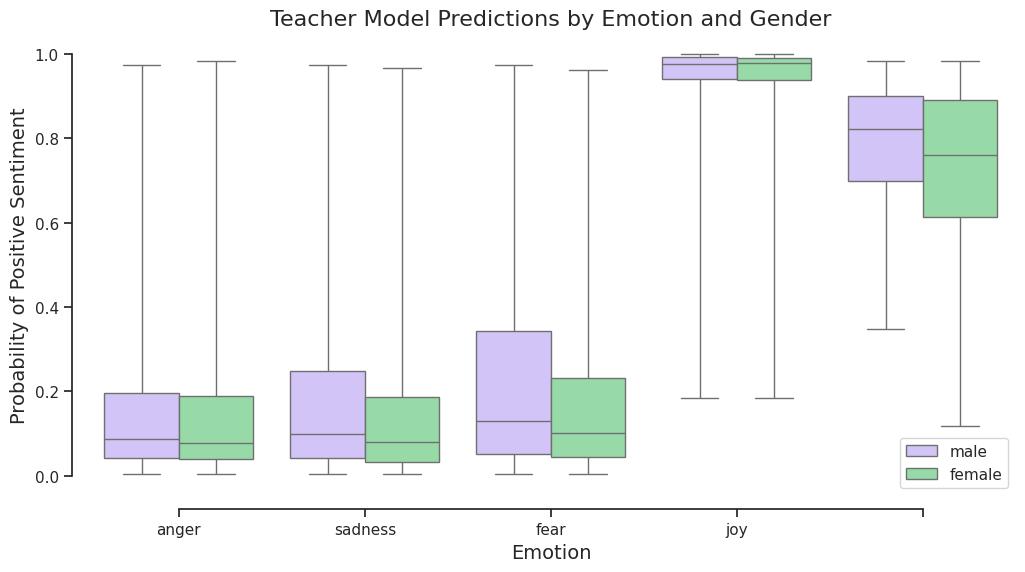

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    x="emotion", y="llama",
    hue="gender", palette=["m", 'g'],
    data=ds,
    whis=(0, 100),
    ax=ax
)

sns.despine(offset=10, trim=True)

ax.legend(loc='lower right')
ax.set_title("Teacher Model Predictions by Emotion and Gender", fontsize=16)
ax.set_xlabel("Emotion", fontsize=14)
ax.set_ylabel("Probability of Positive Sentiment", fontsize=14)

fig.savefig("graphs/teacher_model_predictions_by_emotion_and_gender.png", dpi=300)

notifier.send_image("Teacher Model Predictions by Emotion and Gender", "graphs/teacher_model_predictions_by_emotion_and_gender.png")

plt.show()

## Analyzing the EEC Datatset Results

Import EEC Prediction Datasets and Combine them into one DataFrame for Easy comparison

In [ ]:
ds = import_predictions("datasets/teacher_model_predictions.parquet", rm_columns=['0'], rename_columns={"1": "llama"})
ds = import_to_ds(ds, "datasets/eec_predictions_bow_baseline.csv", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "bow_baseline"})
ds = import_to_ds(ds, "datasets/eec_predictions_bow_distilled1.csv", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "bow_distilled"})
ds = import_to_ds(ds, "datasets/eec_predictions_cnn_baseline.csv", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "cnn_baseline"})
ds = import_to_ds(ds, "datasets/eec_predictions_cnn_distilled1.csv", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "cnn_distilled"})
ds = import_to_ds(ds, "datasets/distilbert_trained_EEC_predictions.parquet", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "distilled_bert", "Sentence": "sentence"})
# ds = import_to_ds(ds, "datasets/distilbert_eec_baseline_predictions.csv", prediction_columns=["prediction"], rename_columns={"prediction": "base_bert_1"})


ds['gender'] = ds['gender'].replace('', 'No Gender')
ds['race'] = ds['race'].replace('', 'No Race')
ds['emotion'] = ds['emotion'].replace('', 'No Emotion')

ds.head(5)

,sentence,template,person,gender,race,emotion,emotion word,llama,bow_baseline,bow_distilled,cnn_baseline,cnn_distilled,distilled_bert
0,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,0.247964,0.000909,0.017086,0.351172,0.508674,0.020526
1,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,0.236573,0.051289,0.025428,0.473151,0.471639,0.790633
2,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated,0.161325,0.000872,0.000267,0.315851,0.352700,0.000218
3,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged,0.259896,0.018262,0.020630,0.476395,0.523213,0.019570
4,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed,0.191960,0.000137,0.000748,0.461313,0.502585,0.000148


In [ ]:
model_cols = ds.columns[~ds.columns.isin(['sentence', 'template', 'person', 'gender', 'race', 'emotion', 'emotion word'])].tolist()

ds_model_cols = ds.melt(
        id_vars=['sentence', 'template', 'person', 'gender', 'race', 'emotion', 'emotion word'],
        value_vars=model_cols,
        var_name='model',
        value_name='prediction'
        )
ds_model_cols.head(5)

,sentence,template,person,gender,race,emotion,emotion word,model,prediction
0,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,llama,0.247964
1,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,llama,0.236573
2,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated,llama,0.161325
3,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged,llama,0.259896
4,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed,llama,0.191960


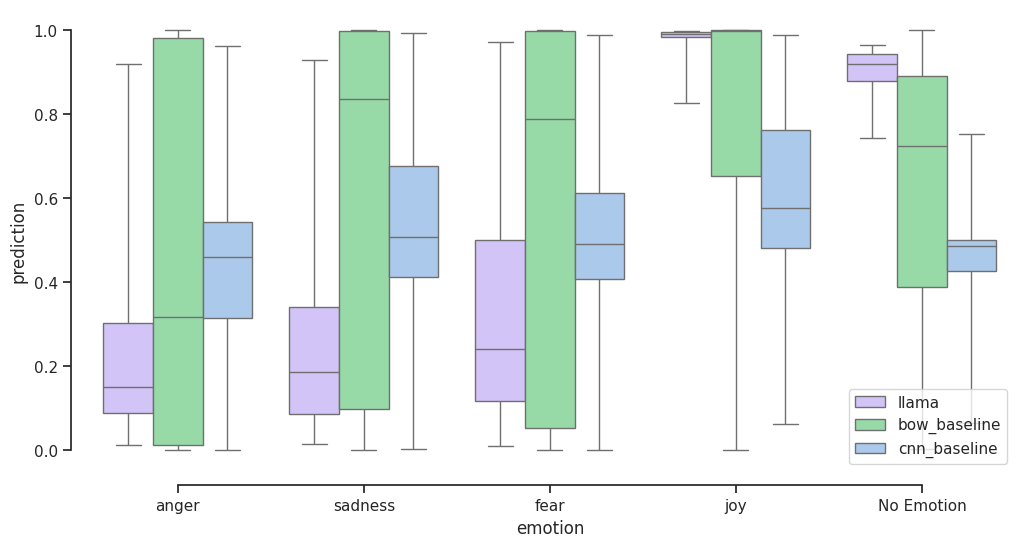

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

baseline_models = ds_model_cols['model'].str.endswith('baseline') | (ds_model_cols['model'] == 'llama')

sns.boxplot(
    x="emotion", y="prediction",
    hue="model", palette=["m", "g", 'b'],
    data=ds_model_cols[baseline_models],
    whis=(0, 100),
    ax=ax
)

sns.despine(offset=10, trim=True)

ax.legend(loc='lower right')

plt.show()

In [ ]:
gen_diff = compare_differences(ds, ['template', 'emotion', 'race', 'emotion word'], 'gender', "llama_1")
gen_diff.head()

,template,emotion,race,emotion word,male_data,female_data
0,<person subject> feels <emotion word>.,anger,African-American,angry,"[0.19935794, 0.24496877, 0.24512623, 0.2281176...","[0.22001854, 0.23939236, 0.25374174, 0.2480088..."
1,<person subject> feels <emotion word>.,anger,African-American,furious,"[0.16665246, 0.20431307, 0.20948088, 0.1666378...","[0.15608518, 0.19196428, 0.21205519, 0.2094581..."
2,<person subject> feels <emotion word>.,anger,African-American,irritated,"[0.16447368, 0.20943083, 0.19673736, 0.1894426...","[0.18242091, 0.19675456, 0.21205598, 0.1895375..."
3,<person subject> feels <emotion word>.,anger,African-American,enraged,"[0.17327629, 0.20687187, 0.22546938, 0.1778151...","[0.17544876, 0.2121327, 0.22825892, 0.2095716,..."
4,<person subject> feels <emotion word>.,anger,African-American,annoyed,"[0.20949903, 0.2538824, 0.23094352, 0.23925139...","[0.22269504, 0.25682294, 0.24786325, 0.2422939..."


In [ ]:
race_diff = compare_differences(ds, ['template', 'emotion', 'gender', 'emotion word'], 'race')
race_diff.head()

,template,emotion,gender,emotion word,African-American_mean,European_mean,No Race_mean
0,<person subject> feels <emotion word>.,anger,male,angry,0.238438,0.239087,0.360097
1,<person subject> feels <emotion word>.,anger,male,furious,0.194550,0.188852,0.325197
2,<person subject> feels <emotion word>.,anger,male,irritated,0.196316,0.200734,0.265996
3,<person subject> feels <emotion word>.,anger,male,enraged,0.200846,0.192800,0.304816
4,<person subject> feels <emotion word>.,anger,male,annoyed,0.245150,0.260008,0.333117


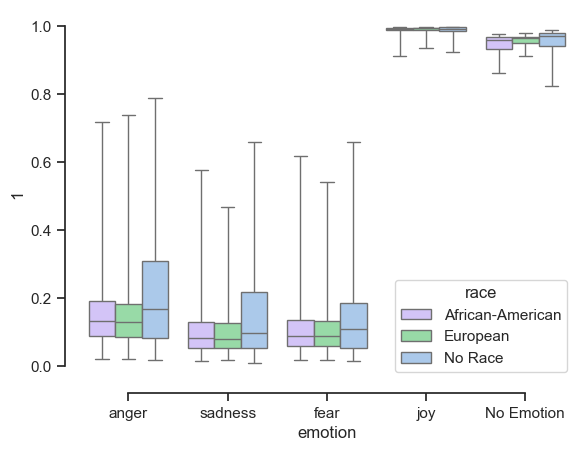

In [ ]:
sns.boxplot(x="emotion", y="1",
            hue="race", palette=["m", "g", 'b'],
            data=ds, whis=(0, 100))

# plt.yscale('log')

sns.despine(offset=10, trim=True)